In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import dictys
from dictys.net import stat
import joblib

In [2]:
from utils_custom import *

In [3]:
# Define file paths 
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output'

In [4]:
# Load data
dictys_dynamic_object = dictys.net.dynamic_network.from_file(os.path.join(output_folder, 'dynamic.h5'))

# Rank TFs unbiasedly based on their expression and regulation curve chars

# Get the top genes of TF subnetworks based on the beta curve chars

In [5]:
# load ranked TFs list 
ranked_tfs_pb = pd.read_csv(os.path.join(output_folder, 'ranked_tfs_pb.csv'))
pb_top_tfs = ranked_tfs_pb[0:15]
#convert to list of TF_name
pb_top_tfs_list = pb_top_tfs['TF_name'].tolist()
# get tf_indices from pb_top_tfs_list
tf_indices_top_pb_tfs, _, _ = get_tf_indices(dictys_dynamic_object, pb_top_tfs_list)
display(tf_indices_top_pb_tfs)

[225, 305, 25, 150, 243, 251, 299, 303, 68, 36, 48, 133, 46, 118, 134]

In [7]:
# get the edge strengths of the top tfs with all relevant genes (dropping genes based on sparsity)
pts, fsmooth = dictys_dynamic_object.linspace(0,2,100,0.0005)
stat1_net = fsmooth(stat.net(dictys_dynamic_object))
stat1_netbin = stat.fbinarize(stat1_net,sparsity=0.01)

In [35]:
stat1_x=stat.pseudotime(dictys_dynamic_object,pts)
dtime = pd.Series(stat1_x.compute(pts)[0])

In [10]:
# compute the binary network to get the indices of genes to keep based on sparsity
dnetbin = stat1_netbin.compute(pts)

In [11]:
display(dnetbin.shape)

(551, 11907, 100)

In [32]:
subnetworks_bin = dnetbin[np.ix_(tf_indices_top_pb_tfs, range(dnetbin.shape[1]), range(dnetbin.shape[2]))]
display(subnetworks_bin.shape)

(15, 11907, 100)

In [33]:
# Calculate sparsity for each gene (across all TFs and timepoints)
# Mean across TFs (axis 0) and time (axis 2)
gene_density = (subnetworks_bin != 0).mean(axis=(0, 2))  # Shape: (11907,)
# Keep genes that are non-zero more than 20% of the time
genes_to_keep = gene_density > 0.05
genes_to_keep_indices = np.where(genes_to_keep)[0]
# Create reverse mapping: index -> gene_name
ndict = dictys_dynamic_object.ndict
index_to_gene = {idx: name for name, idx in ndict.items()}
# Get gene names for kept indices directly
kept_target_names = [index_to_gene[idx] for idx in genes_to_keep_indices]
print(len(genes_to_keep_indices))

647


In [29]:
dnet = stat1_net.compute(pts)
display(dnet.shape)

(551, 11907, 100)

In [30]:
# Filter the subnetworks array to keep only non-sparse genes
filtered_subnetworks = dnet[np.ix_(tf_indices_top_pb_tfs,genes_to_keep_indices, range(dnet.shape[2]))]
print(filtered_subnetworks.shape)

(15, 647, 100)


In [34]:
# Create multi-index tuples (all combinations of TF-target pairs)
index_tuples = [(tf, target) for tf in pb_top_tfs_list for target in kept_target_names]
multi_index = pd.MultiIndex.from_tuples(index_tuples, names=['TF', 'Target'])
# Reshape the subnetworks array to 2D (pairs × time points)
n_tfs, n_targets, n_times = filtered_subnetworks.shape
reshaped_data = filtered_subnetworks.reshape(-1, n_times)

# Create DataFrame with multi-index
betas_dcurve = pd.DataFrame(
    reshaped_data,
    index=multi_index,
    columns=[f'time_{i}' for i in range(n_times)]
)
display(betas_dcurve.head())

time_0    time_1    time_2    time_3    time_4    time_5  \
TF    Target                                                               
PRDM1 ABCC1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
      ACADM   0.022965  0.023116  0.023237  0.023335  0.023417  0.023492   
      ACADVL -0.000126 -0.000105 -0.000087 -0.000072 -0.000058 -0.000047   
      ACAP1  -0.001366 -0.001227 -0.001097 -0.000975 -0.000863 -0.000759   
      ACAT2   0.002176  0.002328  0.002477  0.002622  0.002761  0.002893   

                time_6    time_7    time_8    time_9  ...       time_90  \
TF    Target                                          ...                 
PRDM1 ABCC1   0.000000  0.000000  0.000000  0.000000  ...  0.000000e+00   
      ACADM   0.023570  0.023663  0.023781  0.023938  ...  8.242913e-02   
      ACADVL -0.000037 -0.000029 -0.000022 -0.000017  ...  2.175080e-18   
      ACAP1  -0.000665 -0.000579 -0.000502 -0.000434  ... -1.034296e-17   
      ACAT2   0.003016  0.003128  0.003229  0.003318  ...  1.137932e-10   

                   time_91       time_92       time_93       time_94  \
TF    Target                                                           
PRDM1 ABCC1   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      ACADM   8.101511e-02  7.948645e-02  7.785483e-02  7.613230e-02   
      ACADVL  1.180057e-18  6.384289e-19  3.444578e-19  1.853553e-19   
      ACAP1  -5.570750e-18 -2.992482e-18 -1.603353e-18 -8.569104e-19   
      ACAT2   7.304838e-11  4.676898e-11  2.986679e-11  1.902533e-11   

                   time_95       time_96       time_97       time_98  \
TF    Target                                                           
PRDM1 ABCC1   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
      ACADM   7.433100e-02  7.246304e-02  7.054028e-02  6.857421e-02   
      ACADVL  9.948320e-20  5.325988e-20  2.844365e-20  1.515421e-20   
      ACAP1  -4.568560e-19 -2.429902e-19 -1.289409e-19 -6.826717e-20   
      ACAT2   1.208974e-11  7.664277e-12  4.847544e-12  3.059112e-12   

                   time_99  
TF    Target                
PRDM1 ABCC1   0.000000e+00  
      ACADM   6.657586e-02  
      ACADVL  8.055118e-21  
      ACAP1  -3.606439e-20  
      ACAT2   1.926275e-12  

[5 rows x 100 columns]

In [36]:
import pandas as pd
import numpy as np
from multiprocessing import Pool
import math
from tqdm import tqdm

def process_chunk(args):
    """Process a chunk of curves to compute characteristics"""
    chunk_df, dtime = args
    results = {}
    for idx in chunk_df.index:
        curve = chunk_df.loc[idx]
        char_dict = compute_curve_characteristics(pd.DataFrame(curve).T, dtime)
        results[idx] = char_dict.iloc[0]
    return pd.DataFrame.from_dict(results, orient='index')

# Split data into chunks
n_cores = 8  # Adjust based on your CPU
chunk_size = math.ceil(len(betas_dcurve) / n_cores)
chunks = []

for i in range(0, len(betas_dcurve), chunk_size):
    chunk = betas_dcurve.iloc[i:i + chunk_size]
    chunks.append((chunk, dtime))

# Process chunks in parallel with progress bar
with Pool(n_cores) as pool:
    results = list(tqdm(
        pool.imap(process_chunk, chunks),
        total=len(chunks),
        desc="Processing curves"
    ))

# Combine results and sort
final_dchar = pd.concat(results).sort_index()
final_dchar.to_csv(os.path.join(output_folder, 'betas_chars_15_647.csv'))


Processing curves: 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]


In [38]:
def get_top_curves_by_category(dchar, ntops=(20,20,30,30)):
    """
    Get top curves for different patterns based on Terminal and Transient logFC.
    
    Parameters:
    -----------
    dchar : pd.DataFrame
        DataFrame with curve characteristics, having multi-index (TF, Target)
        and columns ['Terminal logFC', 'Transient logFC', 'Switching time']
    ntops : tuple
        Number of top curves to return for (activating, inactivating, transient_up, transient_down)
    """
    categories = {}
    
    # Activating (positive Terminal logFC)
    t1 = dchar.sort_values('Terminal logFC', ascending=False).head(ntops[0])
    categories['activating'] = t1.sort_values('Switching time')
    
    # Inactivating (negative Terminal logFC)
    t1 = dchar.sort_values('Terminal logFC', ascending=True).head(ntops[1])
    categories['inactivating'] = t1.sort_values('Switching time')
    
    # Transient up
    t1 = dchar.sort_values('Transient logFC', ascending=False).head(ntops[2])
    categories['transient_up'] = t1
    
    # Transient down
    t1 = dchar.sort_values('Transient logFC', ascending=True).head(ntops[3])
    categories['transient_down'] = t1
    
    # Extract TF-target pairs for each category
    activating_pairs = [(idx[0], idx[1]) for idx in categories['activating'].index]
    inactivating_pairs = [(idx[0], idx[1]) for idx in categories['inactivating'].index]
    transient_up_pairs = [(idx[0], idx[1]) for idx in categories['transient_up'].index]
    transient_down_pairs = [(idx[0], idx[1]) for idx in categories['transient_down'].index]
    
    return {
        'activating': activating_pairs,
        'inactivating': inactivating_pairs,
        'transient_up': transient_up_pairs,
        'transient_down': transient_down_pairs
    }

In [39]:
sorted_categories = get_top_curves_by_category(final_dchar, ntops=(20,20,30,30))

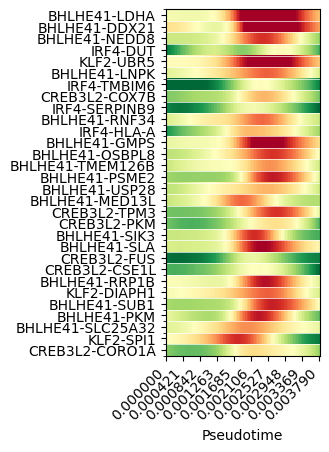

In [46]:
fig, ax, dnet = fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=2,
    regulations=sorted_categories['transient_down'],
    num=100,
    dist=0.0005,
    cmap='RdYlGn' #red is low, green is high
)

In [47]:
# Convert dnet to DataFrame with row labels
df = pd.DataFrame(dnet, 
                 index=["-".join(x) for x in sorted_categories['transient_down']])
print("DataFrame values range:", df.values.min(), "to", df.values.max())
# Calculate max absolute value for symmetric color scaling
vmax_val = float(df.abs().values.max())  # Get max from numpy array values

DataFrame values range: -0.45411423323397027 to 0.28250742483385227


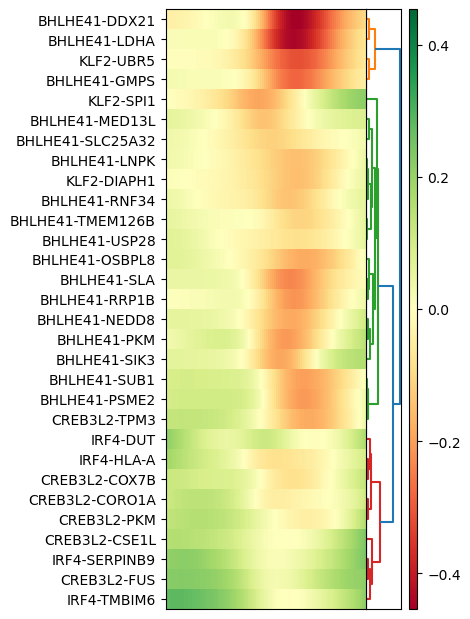

In [48]:
# Use cluster_heatmap with absolute values for clustering
fig, x, y = cluster_heatmap(df.abs(),  # Use absolute values for clustering
                           dshow=df,    # Show original values in heatmap
                           dtop=0,      # No clustering on time points
                           dright=0.3,  # Cluster the links
                           method='ward',
                           metric='euclidean',
                           cmap='RdYlGn',   # Use the colormap name directly
                           aspect=0.1,
                           xtick=False,
                           vmin=-vmax_val,  # Set minimum value
                           vmax=vmax_val)   # Set maximum value